<img src='../source_figures/bnl_logo_horizontal_rgb.png' width="400" height="400">

# steady as beamlines go

### Anomaly Detection with ML and Scalar Time Series

### Andi Barbour, Soft X-ray Scattering and Spectroscopy, CSX, NSLS-II

### NSLS-II and CFN Users' Meeting 2022
Workshop 6

Notebook #1

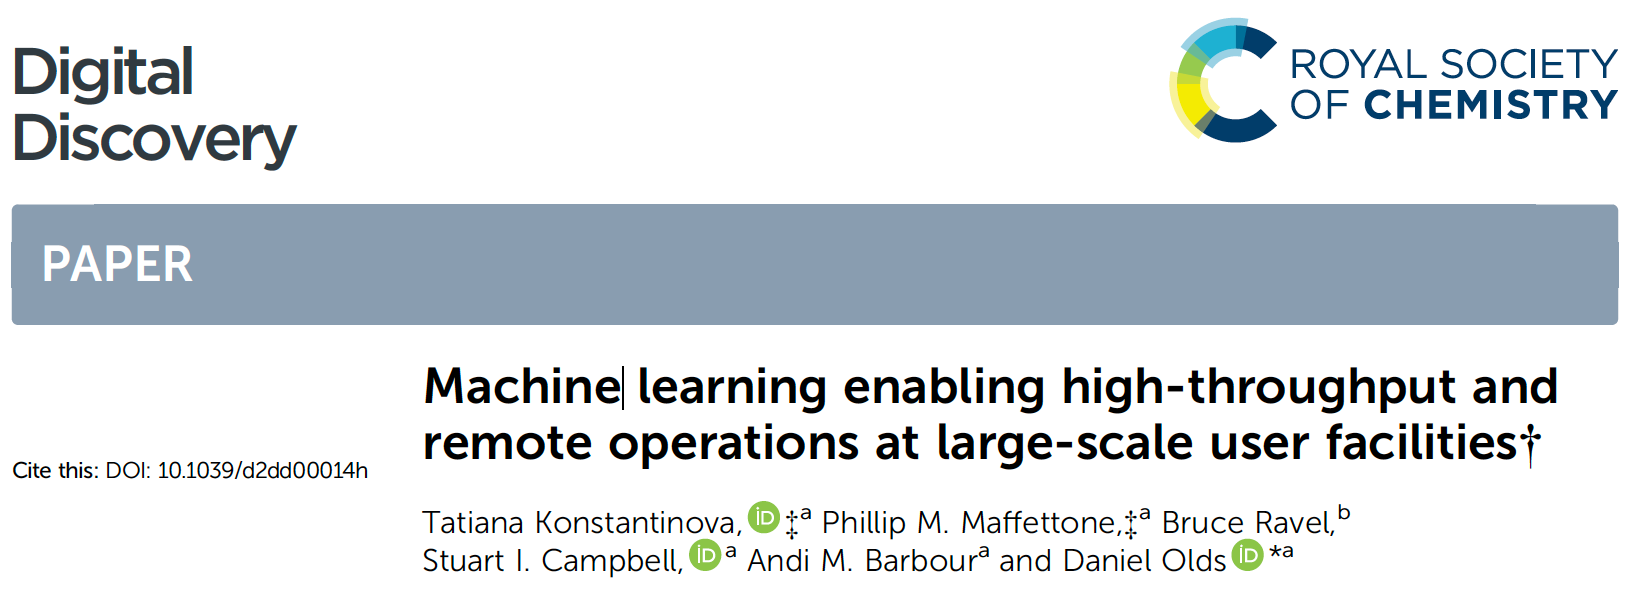<img src='figures/3pp.png' width="1000" height="1000">

*Figures found here are from the DOI above.*


# Find it on github
[data, models, training notebooks, and example implementation](https://github.com/bnl/pub-ML_examples)

### 3 Anomaly Detection Models

**Based on 3 unsupervised algorithms from sklearn**
- Local Outlier Detection (LOD)
- Elliptical Envelope (EE)
- Isolation Forest (IFT)
    


<img src='figures/3types_anomaly.png' width="2000" height="2000">

   
**Scalar data from process Area Detector Images**
- 6 scalar signals for each "measurement"
-  feature engineering (93)
- no labels used during training (`model.fit()`)
- labels are to evaluate model performance
-  **semi-supervised** models
     
     

### Basic concept
- Normal data is easy to find
- Large data set should help with performance
    - Number of frames, 20 - 14,000
    - Many measurements in 1 "time scan" 
- Data collected at CSX beamline

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import pickle

### Load all 3 models from disk
* not training
* let's just use as executables
* if you don't our pickle files on your personal computer, you can train from scatch

In [ ]:
def make_the_model_go(model, input_data):
    prediction = "anomaly" if model.predict(input_data) == -1 else "normal"
    print(f"The model characterize the data as {prediction}")

models = {}
model_types = ['EE', 'IFT', 'LOD']
for mod_type in model_types:
    with open(f'models/anomaly_detection_{mod_type}_model.pk', 'rb') as f:
        temp = pickle.load(f)
        models.update({mod_type : temp})

### Retrieve all collected data 
* Available as `.csv` and `.h5` *(only `.csv` here)*


In [ ]:
df = pd.read_csv("anomaly/CSX_data.csv",index_col=0)
df.head()


### Prepare data for model input
- just looking at 1 measurement first

In [ ]:
csx_labeled_data = df.drop(columns=["target", "roi"])#.to_numpy() 
print(csx_labeled_data.shape)
measurements, features = csx_labeled_data.shape
print(f'\n{measurements} individual measurements to test')
print(f'\n{features} engineered features per measurement')
 

In [ ]:
data = csx_labeled_data[0:1]
for method, model in models.items():
    print(f'{method}:\t', end="")
    make_the_model_go(model, data)

### Make target (labels) numerical
- `"normal" = 1`
- `"anomaly" = -1`

In [ ]:
df.loc[df['target'] == 'normal', 'target'] = 1
df.loc[df['target'] == 'anomaly', 'target'] = -1

In [ ]:
df.head()

### Pass all data through all models

In [ ]:
prediction_results = {'EEpr':[], 'IFTpr':[],'LODpr':[],}


for i in range(csx_labeled_data.shape[0]):
    data =  csx_labeled_data[i:i+1]
    for method, model in models.items():
        #print(f'{method}:\t', end="")
        prediction = model.predict(data)
        prediction_results[method+'pr'].append(prediction[0])

### Copy target to results dataframe (`df_res`) for convenience

In [ ]:
df_res = pd.DataFrame(prediction_results)
df_res['target'] = df['target']

In [ ]:
df_res.head()

### Performance versus Target 
* just make sure nothing is wrong here

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.title(f'Reproducing Results from CSX_data.csv\nWith Models from Disk')
for method, color in zip(models.keys(), ['blueviolet', 'lime', 'deepskyblue']):
    plt.hist(df_res[method+'pr'],bins=2,histtype='step', label = method+'pr',lw=5, color = color)
    
plt.hist(df_res['target'],bins=2,histtype='step', label = 'target', color='deeppink', lw=3)
plt.ylabel("Measurements")
plt.xlabel("Predictions")
plt.legend(loc=6)
fig.savefig("Histogram_of_Predictions_for_CSX-FCCD_labeled_data.png")

### Tally Overall Average Performance
* Overall is a more coarse estimation
* For fine hyperparameter tuning for desired performance requires
    * Recall anomaly
    * False anomaly discovery rate


In [ ]:
df_res_total = df_res
for method in models.keys():
    conditions = [
        (df_res_total[method+'pr'] == df_res_total['target']),
        (df_res_total[method+'pr'] != df_res_total['target'])
    ]

    label_match = [True, False]
    df_res_total[method+'pr'] = np.select(conditions, label_match )
    
for method in models.keys():
    print(f'{method}:\t {df_res_total[method+"pr"].value_counts()[1] / measurements *100:.2f}% overall')

### Published Results    
<img src='figures/3pp_anomaly_results_paper.png' width="500" height="500">

### Acknowledgements

These data herein were used to train the **EE**, **IFT**, and **LOD** models and the data were collected at the **CSX beamline of the National Synchrotron Light Source II**, a U.S. Department of Energy (DOE) Office of Science User Facility operated for the DOE Office of Science by Brookhaven National Laboratory (BNL) under **Contract No. DE-SC0012704**.

The paper and approach were developed in colllaboartion with resources of a BNL Laboratory Directed Research and Development (LDRD) projects:
- **20-032 ”Accelerating materials discovery with total scattering via machine learning”**
- **20-038 ”Machine Learning for Real-Time Data Fidelity, Healing, and Analysis for Coherent X-ray Synchrotron Data”**. 